In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.transforms import ToTensor, Resize
from PIL import Image
import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from siren import siren_model

device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

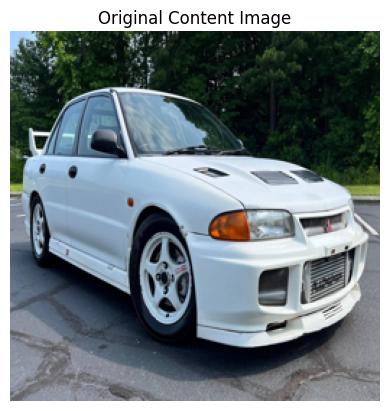

In [4]:
img = Image.open("objects.jpg").convert("RGB")
img = img.resize((256, 256))
plt.imshow(img); plt.title("Original Content Image"); plt.axis("off"); plt.show()


to_tensor = T.ToTensor()
img_tensor = to_tensor(img).unsqueeze(0).to(device)
H, W = img_tensor.shape[2], img_tensor.shape[3]

In [5]:
# H, W = 256, 256
ys = torch.linspace(-1, 1, H)
xs = torch.linspace(-1, 1, W)
coords = torch.stack(torch.meshgrid(ys, xs, indexing="ij"), dim=-1)
coords = coords.reshape(-1, 2).to(device)


In [6]:
siren = siren_model([2, H, W, 3]).to(device)

In [7]:
style_prompt = "a watercolor landscape painting"
text_tokens = clip.tokenize([style_prompt]).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).detach()

clip_preprocess = T.Compose([
    T.Resize((224, 224)),
    T.Normalize([0.48145466, 0.4578275, 0.40821073],
                [0.26862954, 0.26130258, 0.27577711])
])
optimizer = torch.optim.Adam(siren.parameters(), lr=1e-3)


Step 0 | Style Loss: -0.1592 | Content Loss: 0.2353


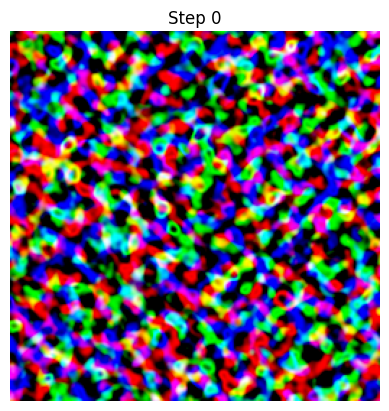

Step 100 | Style Loss: -0.4473 | Content Loss: 0.0227


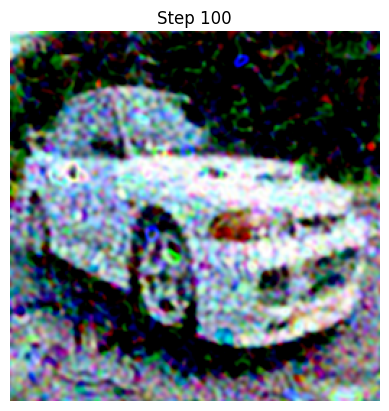

Step 200 | Style Loss: -0.5391 | Content Loss: 0.0175


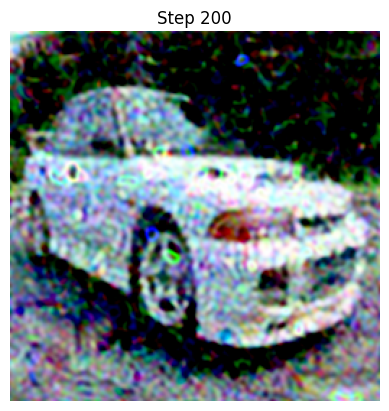

Step 300 | Style Loss: -0.5933 | Content Loss: 0.0161


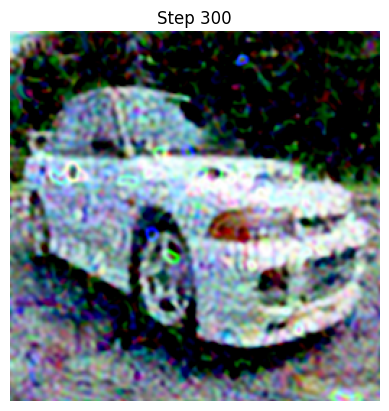

Step 400 | Style Loss: -0.6323 | Content Loss: 0.0153


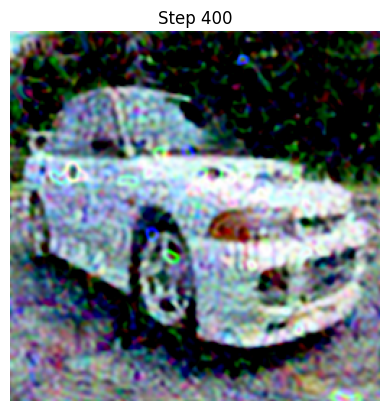

Step 500 | Style Loss: -0.6367 | Content Loss: 0.0150


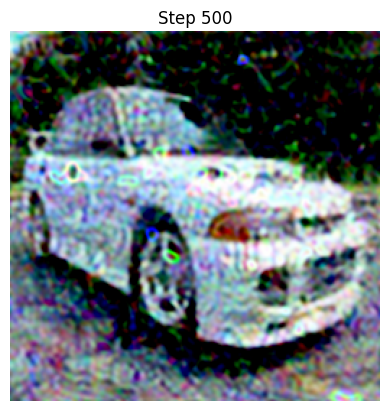

In [8]:
num_steps = 501
losses = []

for step in range(num_steps):
    rgb = siren(coords)
    img_out = rgb.reshape(1, H, W, 3).permute(0, 3, 1, 2).contiguous()

    img_out_clamped = img_out.clamp(0, 1)
    
    # print("siren:", rgb.shape)
    
    clip_in = T.Resize((224, 224))(img_out_clamped)
    image_features = clip_model.encode_image(clip_in)
    style_loss = -torch.cosine_similarity(image_features, text_features).mean()

    # print("img_tensor:", img_tensor.shape)
    # print("img_out_clamped:", img_out_clamped.shape)
    
    content_loss = F.mse_loss(img_out_clamped, img_tensor)

    # print(f"Step {step}, Loss: {loss.item():.4f}")
    
    loss = 0.1 * style_loss + 0.9 * content_loss
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0 or step == num_steps - 1:
        print(f"Step {step} | Style Loss: {style_loss.item():.4f} | Content Loss: {content_loss.item():.4f}")
        img_np = img_out_clamped[0].permute(1, 2, 0).detach().cpu().numpy()
        plt.imshow(img_np)
        plt.title(f"Step {step}")
        plt.axis("off")
        plt.show()


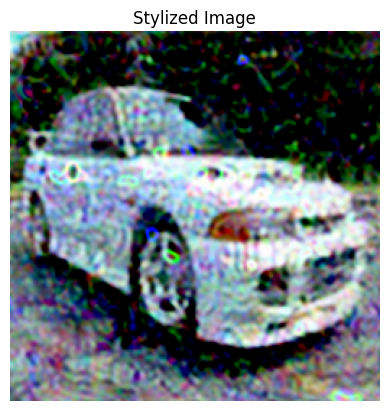

In [9]:
final_img = img_out_clamped[0].permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(final_img)
plt.title("Stylized Image")
plt.axis("off")
plt.show()

In [2]:
torch.cuda.empty_cache()
torch.cuda.synchronize()